# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии, нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов. 

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение - текст имеются оценки от трёх специалистов. Для решения задачи мы должны эти оценки превратить в одну – агрегировать. Существует несколько способов агрегации оценок, одна из самых простых – голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае - 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например, 1, 4, 2. В таком случае можно данную пару изображение - текст исключить из датасета. 

Вы можете воспользоваться другим методом агрегации оценок, или же придумать свой. 

В файле с краудсорсинговыми оценкамисначала доля исполнителей, которые сказали, что текст **соответствует** картинке, затем количество исполнителей, которые сказали, что текст **соответствует** картинке, и наконец количество исполнителей, котооры сказали, что текст **не соответствует** картинке.

После анализа экспертных оценок и краудсорсинговых оценок выберете либо одну из них, либо объедините их в одну по какому-то критерию, например, оценка эксперта принимается с коэффициентом 0.6, а крауда – с коэффициентом 0.4.  

Наша модель на выходе должна возвращать вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1. 


In [3]:
# в авторском примере возьмём экспертные оценки
import pandas as pd
tasks_df = pd.read_csv('/home/jupyter/mnt/s3/datasets/image_search/ExpertAnnotations.tsv', sep='\t', names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
tasks_df.head()

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [4]:
tasks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
image       5822 non-null object
query_id    5822 non-null object
expert_1    5822 non-null int64
expert_2    5822 non-null int64
expert_3    5822 non-null int64
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [5]:
len(tasks_df.image.unique())

1000

In [6]:
tasks_df = tasks_df[
    ~(
        (tasks_df.expert_1 != tasks_df.expert_2) 
        & (tasks_df.expert_1 != tasks_df.expert_3) 
        & (tasks_df.expert_2 != tasks_df.expert_3)
    )
].reset_index(drop=True)
tasks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 5 columns):
image       5696 non-null object
query_id    5696 non-null object
expert_1    5696 non-null int64
expert_2    5696 non-null int64
expert_3    5696 non-null int64
dtypes: int64(3), object(2)
memory usage: 222.6+ KB


In [7]:
len(tasks_df.image.unique())

1000

In [8]:
tasks_df['aggregated_score'] = (tasks_df[['expert_1', 'expert_2', 'expert_3']].mode(axis=1) - 1)/3
tasks_df.head()

,image,query_id,expert_1,expert_2,expert_3,aggregated_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.000000


In [9]:
tasks_df.drop(columns=['expert_1', 'expert_2', 'expert_3'], inplace=True)
tasks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 3 columns):
image               5696 non-null object
query_id            5696 non-null object
aggregated_score    5696 non-null float64
dtypes: float64(1), object(2)
memory usage: 133.6+ KB


In [10]:
tasks_df.describe()

,aggregated_score
count,5696.000000
mean,0.203827
std,0.286367
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,1.000000


## 2. Проверка данных

В некоторых странах, где работает ваша компания действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому, все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [31]:
train_df = pd.read_csv('/home/jupyter/mnt/s3/datasets/image_search/train_dataset.csv')
train_df.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
image         5822 non-null object
query_id      5822 non-null object
query_text    5822 non-null object
dtypes: object(3)
memory usage: 136.6+ KB


In [33]:
children_mask = (
    train_df.query_text.str.contains(' child ') 
    | train_df.query_text.str.contains(' children ') 
    | train_df.query_text.str.contains(' kid ') 
    | train_df.query_text.str.contains(' kids ') 
    | train_df.query_text.str.contains(' baby ') 
    | train_df.query_text.str.contains(' babies ') 
    | train_df.query_text.str.contains(' boy ') 
    | train_df.query_text.str.contains(' boys ') 
    | train_df.query_text.str.contains(' girl ') 
    | train_df.query_text.str.contains(' girls ')
)

In [34]:
train_df[children_mask]

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5802,430173345_86388d8822.jpg,523985664_c866af4850.jpg#2,A girl wearing a swimsuit top wears a sign to ...
5803,444481722_690d0cadcf.jpg,1352410176_af6b139734.jpg#2,A young girl balances on wooden pylons at the ...
5804,488408004_a1e26d4886.jpg,1352410176_af6b139734.jpg#2,A young girl balances on wooden pylons at the ...
5814,751109943_2a7f8e117f.jpg,2475162978_2c51048dca.jpg#2,a woman holding a small ball chasing after a s...


In [35]:
print(len(train_df[children_mask].image.unique().tolist()),
      len(train_df.image.unique().tolist()))

700 1000


In [36]:
train_df = train_df[~train_df.image.isin(train_df[children_mask].image.unique().tolist())]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 25 to 5818
Data columns (total 3 columns):
image         1585 non-null object
query_id      1585 non-null object
query_text    1585 non-null object
dtypes: object(3)
memory usage: 49.5+ KB


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ – это просто чтение изображения и превращение полученной матрицы в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям, так как они позволяют "выделить" главные компоненты изображений – как раз то, что нам надо. Как это сделать? Нужно выбрать какую-либо архитектуру, например, ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, претренированную на датасете ImageNet.

In [37]:
import torch
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

In [38]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)
print(list(resnet.children()))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth



[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [39]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

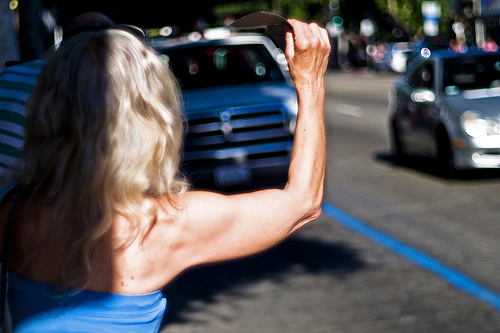

In [40]:
from PIL import Image
import os
img = Image.open(
    os.path.join("/home/jupyter/mnt/s3/datasets/image_search/train_images", tasks_df.iloc[0, 0])
).convert('RGB')
img

In [41]:
from torchvision import transforms
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [47]:
image_tensor = preprocess(img)
image_tensor = image_tensor.unsqueeze(0)
image_tensor

tensor([[[[-1.7583, -1.7925, -1.8097,  ..., -1.9295, -1.8782, -1.6727],
          [-1.9467, -1.9467, -1.9124,  ..., -1.9467, -1.9124, -1.8097],
          [-2.0323, -2.0837, -2.0323,  ..., -1.9980, -1.9295, -1.8439],
          ...,
          [-1.8439, -1.8268, -1.8268,  ..., -0.5767, -0.6109, -0.6109],
          [-1.6555, -1.6042, -1.6042,  ..., -0.5938, -0.5767, -0.5767],
          [-1.0048, -0.9020, -0.9020,  ..., -0.6281, -0.5938, -0.6109]],

         [[-1.6331, -1.6155, -1.5805,  ..., -1.7206, -1.6856, -1.4930],
          [-1.7906, -1.7731, -1.7031,  ..., -1.7556, -1.7381, -1.6506],
          [-1.8431, -1.8782, -1.8431,  ..., -1.7906, -1.7381, -1.6856],
          ...,
          [ 0.2577,  0.2752,  0.2577,  ..., -0.5301, -0.5126, -0.5126],
          [ 0.3978,  0.3803,  0.3978,  ..., -0.5301, -0.4776, -0.4776],
          [ 0.7129,  0.7304,  0.7479,  ..., -0.5476, -0.4951, -0.4951]],

         [[-1.1421, -1.0898, -0.9678,  ..., -1.4210, -1.3687, -1.2816],
          [-1.3164, -1.3339, -

In [48]:
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [49]:
output_tensor = resnet(image_tensor).flatten()
output_tensor

tensor([1.4565, 1.4630, 0.0038,  ..., 0.0000, 0.0000, 0.0000])

In [50]:
output_tensor.shape

torch.Size([25088])

In [52]:
def get_image_embedding(image_path):
    with Image.open(
        os.path.join("/home/jupyter/mnt/s3/datasets/train_images/", image_path)
    ).convert('RGB') as img:
        image_tensor = preprocess(img)
        input_tensor = image_tensor.unsqueeze(0)
    return resnet(input_tensor).flatten().numpy()


image_embeddings = {
    image_path: get_image_embedding(image_path) 
    for image_path in train_df['image'].unique()
}

In [53]:
train_df['image_embedding'] = train_df['image'].map(image_embeddings)
train_df.head()

,image,query_id,query_text,image_embedding
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,"[0.11976217, 1.9785857, 2.789251, 3.3556082, 1..."
29,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,"[0.01566711, 0.0, 0.0, 0.017431881, 0.04016606..."
32,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,"[0.64668643, 1.374203, 1.5152419, 2.111132, 2...."
34,2225231022_1632d0a5aa.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
35,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,"[0.041176677, 0.0, 0.3458461, 0.24155161, 0.25..."


## 4. Векторизация текстов

Следующий этап - векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:
- tf-idf
- word2vec
- \*трансформеры (например, Bert)

\* - если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [54]:
train_df.query_text = train_df.query_text.str.lower()
train_df.query_text = train_df.query_text.str.replace('[^\w\s]$', '', regex=True)
train_df.query_text = train_df.query_text.str.replace('\s+', ' ', regex=True)
train_df.head()

,image,query_id,query_text,image_embedding
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street,"[0.11976217, 1.9785857, 2.789251, 3.3556082, 1..."
29,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...,"[0.01566711, 0.0, 0.0, 0.017431881, 0.04016606..."
32,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time,"[0.64668643, 1.374203, 1.5152419, 2.111132, 2...."
34,2225231022_1632d0a5aa.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
35,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time,"[0.041176677, 0.0, 0.3458461, 0.24155161, 0.25..."


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 25 to 5818
Data columns (total 4 columns):
image              1585 non-null object
query_id           1585 non-null object
query_text         1585 non-null object
image_embedding    1585 non-null object
dtypes: object(4)
memory usage: 61.9+ KB


In [56]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_df['query_embedding'] = train_df['query_text'].apply(
    lambda x: np.array(tokenizer.encode(x, padding='max_length'))
)
train_df.head()

,image,query_id,query_text,image_embedding,query_embedding
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street,"[0.11976217, 1.9785857, 2.789251, 3.3556082, 1...","[101, 1037, 2158, 25126, 2104, 1037, 8768, 200..."
29,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...,"[0.01566711, 0.0, 0.0, 0.017431881, 0.04016606...","[101, 1037, 2450, 3248, 2007, 2146, 2417, 2268..."
32,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time,"[0.64668643, 1.374203, 1.5152419, 2.111132, 2....","[101, 2822, 3006, 2395, 1999, 1996, 3467, 2051..."
34,2225231022_1632d0a5aa.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[101, 2822, 3006, 2395, 1999, 1996, 3467, 2051..."
35,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time,"[0.041176677, 0.0, 0.3458461, 0.24155161, 0.25...","[101, 2822, 3006, 2395, 1999, 1996, 3467, 2051..."


## 5. Объединение векторов 

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной

In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1585 entries, 25 to 5818
Data columns (total 5 columns):
image              1585 non-null object
query_id           1585 non-null object
query_text         1585 non-null object
image_embedding    1585 non-null object
query_embedding    1585 non-null object
dtypes: object(5)
memory usage: 74.3+ KB


In [59]:
tasks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 3 columns):
image               5696 non-null object
query_id            5696 non-null object
aggregated_score    5696 non-null float64
dtypes: float64(1), object(2)
memory usage: 133.6+ KB


In [61]:
train_data = train_df.merge(tasks_df, on=['image', 'query_id'])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1552 entries, 0 to 1551
Data columns (total 6 columns):
image               1552 non-null object
query_id            1552 non-null object
query_text          1552 non-null object
image_embedding     1552 non-null object
query_embedding     1552 non-null object
aggregated_score    1552 non-null float64
dtypes: float64(1), object(5)
memory usage: 84.9+ KB


In [63]:
train_data.aggregated_score.value_counts()

0.000000    742
0.333333    474
0.666667    210
1.000000    126
Name: aggregated_score, dtype: int64

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение нам не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того, чтобы при разбиении учесть изображения, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.



Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```python
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]
```

Какую модель использовать мы оставляем на ваше усмотрение. Также, вам предстоит выбрать метрику качества, либо же реализовать свою.

In [65]:
type(train_data.loc[0, 'image_embedding'])

numpy.ndarray

In [66]:
type(train_data.loc[0, 'query_embedding'])

numpy.ndarray

In [67]:
train_data['image_query'] = train_data.apply(
    lambda x: np.hstack((x['image_embedding'], x['query_embedding'])), axis=1
)
train_data = train_data.drop(columns=['image_embedding', 'query_text', 'query_embedding'])
train_data.head()

,image,query_id,aggregated_score,image_query
0,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,0.333333,"[0.11976216733455658, 1.9785857200622559, 2.78..."
1,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,0.000000,"[0.015667110681533813, 0.0, 0.0, 0.01743188127..."
2,2225231022_1632d0a5aa.jpg,3286822339_5535af6b93.jpg#2,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,0.000000,"[0.041176676750183105, 0.0, 0.3458460867404938..."
4,370614351_98b8a166b9.jpg,3286822339_5535af6b93.jpg#2,0.000000,"[0.8152639269828796, 1.1759495735168457, 0.0, ..."


In [69]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(
    gss.split(
        X=train_data.drop(columns=['aggregated_score']), 
        y=train_data.aggregated_score,
        groups=train_data.image,
    )
)
train, val = train_data.loc[train_indices], train_data.loc[test_indices]
print(train.head(),'\n', val.head())

                       image                     query_id  aggregated_score  \
0   488590040_35a3e96c89.jpg  3181701312_70a379ab6e.jpg#2          0.333333   
2  2225231022_1632d0a5aa.jpg  3286822339_5535af6b93.jpg#2          0.000000   
3  3100251515_c68027cc22.jpg  3286822339_5535af6b93.jpg#2          0.000000   
4   370614351_98b8a166b9.jpg  3286822339_5535af6b93.jpg#2          0.000000   
5  3256043809_47258e0b3e.jpg  3360930596_1e75164ce6.jpg#2          0.000000   

                                         image_query  
0  [0.11976216733455658, 1.9785857200622559, 2.78...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.041176676750183105, 0.0, 0.3458460867404938...  
4  [0.8152639269828796, 1.1759495735168457, 0.0, ...  
5  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                         image                     query_id  aggregated_score  \
1   3251976937_20625dc2b8.jpg  3207358897_bfa61fa3c6.jpg#2          0.000000   
10  3115174046_9e96b9ce47.jpg   4

In [70]:
len(set(train.image.to_list()).intersection(set(val.image.to_list())))

0

In [71]:
np.array(train['image_query'].values.tolist())

array([[0.11976217, 1.97858572, 2.78925109, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04117668, 0.        , 0.34584609, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [72]:
import numpy as np
X_train = torch.tensor(np.array(train['image_query'].values.tolist()), dtype=torch.float)
print(X_train, X_train.shape)

tensor([[0.1198, 1.9786, 2.7893,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0412, 0.0000, 0.3458,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]) torch.Size([1084, 25600])


In [73]:
X_val = torch.tensor(np.array(val['image_query'].values.tolist()), dtype=torch.float)
print(X_val, X_val.shape)

tensor([[0.0157, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [2.7310, 2.7042, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2567, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.1010, 1.2562, 0.5113,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]) torch.Size([468, 25600])


In [74]:
y_train = torch.tensor(train.aggregated_score.values, dtype=torch.float)
print(y_train, y_train.shape)

tensor([0.3333, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]) torch.Size([1084])


In [75]:
y_val = torch.tensor(val.aggregated_score.values, dtype=torch.float)
print(y_val, y_val.shape)

tensor([0.0000, 0.0000, 0.0000, 0.6667, 0.3333, 0.3333, 0.6667, 0.0000, 0.0000,
        0.3333, 1.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000, 1.0000, 0.0000,
        0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
        0.3333, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333,
        0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.6667, 0.3333, 0.6667, 0.0000,
        0.6667, 1.0000, 0.6667, 0.0000, 0.3333, 0.0000, 0.0000, 0.6667, 0.3333,
        0.3333, 0.6667, 0.0000, 0.3333, 0.0000, 1.0000, 0.0000, 1.0000, 0.3333,
        0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.6667, 0.0000, 0.3333,
        0.0000, 0.6667, 0.3333, 0.3333, 1.0000, 0.3333, 0.3333, 0.0000, 1.0000,
        0.0000, 0.3333, 0.3333, 0.0000, 1.0000, 0.3333, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.6667, 0.3333, 0.6667,
        0.3333, 0.3333, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [76]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [77]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = int(X_train.shape[1]*2.0/3.0)
n_hidden_neurons_2 = int(X_train.shape[1]/3.0)
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.Sigmoid()
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

num_epochs = 50

In [78]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_val)
        accuracy = torch.abs(test_preds - y_val).float().mean().data
        print(f'Epoch {epoch}: {accuracy}')

Epoch 0: 0.2713666558265686
Epoch 10: 0.27136749029159546
Epoch 20: 0.27136749029159546
Epoch 30: 0.2713674008846283


KeyboardInterrupt: 

## 7. Тестирование модели
Настало время протестировать нашу модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [79]:
test_images = pd.read_csv('/home/jupyter/mnt/s3/datasets/image_search/test_images.csv')
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [99]:
def get_test_image_embedding(image_path):
    with Image.open(
        os.path.join("/home/jupyter/mnt/s3/datasets/image_search/test_images", image_path)
    ).convert('RGB') as img:
        image_tensor = preprocess(img)
        input_tensor = image_tensor.unsqueeze(0)
    return resnet(input_tensor).flatten().numpy()


image_embeddings = {
    image_path: get_test_image_embedding(image_path) 
    for image_path in test_images['image'].unique()
}

In [100]:
test_images['image_embedding'] = test_images['image'].map(image_embeddings)
test_images.head()

,image,image_embedding
0,3356748019_2251399314.jpg,"[0.0, 0.0, 0.0, 1.1815277, 0.0, 0.0, 0.0, 0.0,..."
1,2887171449_f54a2b9f39.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.12286126, 0.440281..."
2,3089107423_81a24eaf18.jpg,"[0.0, 0.0, 0.0, 0.0, 0.46300772, 1.3253822, 0...."
3,1429546659_44cb09cbe2.jpg,"[0.0, 1.3870658, 0.0, 0.0, 0.021175936, 0.4731..."
4,1177994172_10d143cb8d.jpg,"[0.41090965, 0.48567915, 1.8899062, 1.4742987,..."


In [106]:
test_queries = pd.read_csv('/home/jupyter/mnt/s3/datasets/image_search/test_queries.csv', sep='|')
test_queries.head()

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [107]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
Unnamed: 0    500 non-null int64
query_id      500 non-null object
query_text    500 non-null object
image         500 non-null object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [108]:
children_mask = (
    test_queries.query_text.str.contains(' child ') 
    | test_queries.query_text.str.contains(' children ') 
    | test_queries.query_text.str.contains(' kid ') 
    | test_queries.query_text.str.contains(' kids ') 
    | test_queries.query_text.str.contains(' baby ') 
    | test_queries.query_text.str.contains(' babies ') 
    | test_queries.query_text.str.contains(' boy ') 
    | test_queries.query_text.str.contains(' boys ') 
    | test_queries.query_text.str.contains(' girl ') 
    | test_queries.query_text.str.contains(' girls ')
)

In [109]:
test_queries = test_queries[~test_queries.image.isin(test_queries[children_mask].image.unique().tolist())]
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 15 to 499
Data columns (total 4 columns):
Unnamed: 0    290 non-null int64
query_id      290 non-null object
query_text    290 non-null object
image         290 non-null object
dtypes: int64(1), object(3)
memory usage: 11.3+ KB


In [110]:
test_queries_sample = test_queries.sample(n=10)
test_queries_sample

,Unnamed: 0,query_id,query_text,image
356,356,3466891862_9afde75568.jpg#1,a little white and tan dog running through the...,3466891862_9afde75568.jpg
342,342,3455405300_aa3069ecaa.jpg#2,A group of women wearing red all rally together .,3455405300_aa3069ecaa.jpg
39,39,1745110280_0cbff5e273.jpg#4,The brown dog is wearing a black collar .,1745110280_0cbff5e273.jpg
111,111,2448210587_9fe7ea5f42.jpg#1,An old woman with a white dog,2448210587_9fe7ea5f42.jpg
289,289,3287969199_08e775d896.jpg#4,A large gray bird begins to land in the water .,3287969199_08e775d896.jpg
341,341,3455405300_aa3069ecaa.jpg#1,A group of women all dressed in red with yello...,3455405300_aa3069ecaa.jpg
243,243,3142055158_01b9e4caa4.jpg#3,One rugby player attempts to take down another .,3142055158_01b9e4caa4.jpg
327,327,3421547427_53411b6278.jpg#2,A tennis player in a blue shirt celebrates his...,3421547427_53411b6278.jpg
51,51,1991806812_065f747689.jpg#1,A fighter attempts to kick another fighter whi...,1991806812_065f747689.jpg
87,87,2346402952_e47d0065b6.jpg#2,Two women are operating a laptop connected to ...,2346402952_e47d0065b6.jpg


In [117]:
import re
test_queries_sample.iloc[0, 2].lower()

'a little white and tan dog running through the grass with a stick in his mouth '

In [128]:
def predict_for_pair(image_vector, query_vector):
    t = torch.tensor(np.hstack((image_vector, query_vector)), dtype=torch.float)
    net.eval()

    with torch.no_grad():
        return float(net(t))

query_token = torch.tensor(
    tokenizer.encode(
        re.sub('\s+', ' ', re.sub('[^\w\s]$', '', test_queries_sample.iloc[0, 2].lower())), 
        padding='max_length')
)
predict_for_pair(test_images.iloc[0,1], query_token)

2.30143779589298e-08

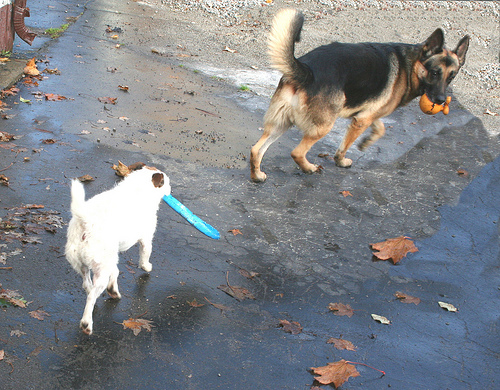

In [133]:
def get_image_for_query(images, query):
    query = re.sub('\s+', ' ', re.sub('[^\w\s]$', '', query.lower()))
    query_token = torch.tensor(tokenizer.encode(query, padding='max_length'))
    images_temp = images.copy()
    for index, row in images_temp.iterrows():
        images_temp.loc[index, 'similarity'] = predict_for_pair(row['image_embedding'], query_token)
    images_temp.sort_values('similarity', ascending=False, inplace=True)
    return images_temp.iloc[0,0]
    
img = Image.open(
    os.path.join("/home/jupyter/mnt/s3/datasets/image_search/test_images", 
                 get_image_for_query(test_images, test_queries_sample.iloc[0, 2]))).convert('RGB')
img

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений.
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели 
- [ ]  По итогам тестирования визуально сравнили качество поиска